In [16]:
# Cell 1: imports (put this at the top)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Lightning (if installed)
try:
    import pytorch_lightning as pl
    from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
except Exception:
    pl = None
    print("pytorch_lightning not available. Install if you want to use Trainer API.")

In [17]:
# Cell 0 — run if lightning not installed (Colab)
!pip install -q pytorch-lightning

In [18]:
# Step 2
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_instances(sequence, window_size):
    #sequence: list of SoH
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
from sklearn.model_selection import train_test_split

def get_train_test(data_dict, name, window_size=8, test_size=0.2):
    data_sequence = data_dict[name]['SoH'].values  # ensure numpy array
    X, y = build_instances(data_sequence, window_size)

    # split 80/20
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=test_size, shuffle=False  # keep temporal order
    )
    return train_x, train_y, test_x, test_y


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    rmse = np.sqrt(np.mean((y_predict - y_test)**2))
    mae = mean_absolute_error(y_test, y_predict)
    mape = np.mean(np.abs((y_test - y_predict) / (y_test + 1e-8))) * 100
    r2 = r2_score(y_test, y_predict)
    return [rmse, mae, mape, r2]


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [19]:
from google.colab import drive
drive.mount('/content/drive')

# Path jaha tumne rar ka extracted folder upload kiya
data_path = "/content/drive/MyDrive/DeepLearningProject/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Step 3
import os
import glob
import numpy as np
import pandas as pd

# List of batteries to process
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path =  '/content/drive/MyDrive/Dataset/'
npy_path = os.path.join(dir_path, "CALCE.npy")



# --- Function to drop outliers (kept from your code) ---
def drop_outlier(data, count, threshold):
    idx = np.arange(count)
    if len(data) > threshold:
        mean, std = np.mean(data), np.std(data)
        mask = np.abs(data - mean) < 3 * std
        idx = idx[mask]
    return idx

# --- Load from .npy if exists ---
if os.path.exists(npy_path):
    print("✅ Found CALCE.npy, loading preprocessed dataset...")
    Battery = np.load(npy_path, allow_pickle=True).item()

else:
    print("⚙️ CALCE.npy not found, preprocessing .xlsx files...")
    Battery = {}
    for name in Battery_list:
        print('Load Dataset ' + name + ' ...')
        path = glob.glob(dir_path + name + '/*.xlsx')
        dates = []
        for p in path:
            df = pd.read_excel(p, sheet_name=1)
            print('Load ' + str(p) + ' ...')
            dates.append(df['Date_Time'][0])
        idx = np.argsort(dates)
        path_sorted = np.array(path)[idx]

        count = 0
        discharge_capacities = []
        health_indicator = []
        internal_resistance = []
        CCCT = []
        CVCT = []
        for p in path_sorted:
            df = pd.read_excel(p, sheet_name=1)
            print('Load ' + str(p) + ' ...')
            cycles = list(set(df['Cycle_Index']))
            for c in cycles:
                df_lim = df[df['Cycle_Index'] == c]
                # Charging
                df_c = df_lim[(df_lim['Step_Index'] == 2) | (df_lim['Step_Index'] == 4)]
                # CC or CV
                df_cc = df_lim[df_lim['Step_Index'] == 2]
                df_cv = df_lim[df_lim['Step_Index'] == 4]
                if not df_cc.empty and not df_cv.empty:
                    CCCT.append(np.max(df_cc['Test_Time(s)']) - np.min(df_cc['Test_Time(s)']))
                    CVCT.append(np.max(df_cv['Test_Time(s)']) - np.min(df_cv['Test_Time(s)']))

                # Discharging
                df_d = df_lim[df_lim['Step_Index'] == 7]
                d_v = df_d['Voltage(V)']
                d_c = df_d['Current(A)']
                d_t = df_d['Test_Time(s)']
                d_im = df_d['Internal_Resistance(Ohm)']

                if len(d_c) != 0:
                    time_diff = np.diff(list(d_t))
                    d_c = np.array(list(d_c))[1:]
                    discharge_capacity = time_diff * d_c / 3600  # Q = A*h
                    discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                    discharge_capacities.append(-1 * discharge_capacity[-1])

                    dec = np.abs(np.array(d_v) - 3.8)[1:]
                    start = np.array(discharge_capacity)[np.argmin(dec)]
                    dec = np.abs(np.array(d_v) - 3.4)[1:]
                    end = np.array(discharge_capacity)[np.argmin(dec)]
                    health_indicator.append(-1 * (end - start))

                    internal_resistance.append(np.mean(np.array(d_im)))
                    count += 1

        discharge_capacities = np.array(discharge_capacities)
        health_indicator = np.array(health_indicator)
        internal_resistance = np.array(internal_resistance)
        CCCT = np.array(CCCT)
        CVCT = np.array(CVCT)

        idx = drop_outlier(discharge_capacities, count, 40)
        df_result = pd.DataFrame({
            'cycle': np.linspace(1, idx.shape[0], idx.shape[0]),
            'capacity': discharge_capacities[idx],
            'SoH': health_indicator[idx],
            'resistance': internal_resistance[idx],
            'CCCT': CCCT[idx],
            'CVCT': CVCT[idx]
        })
        Battery[name] = df_result

    # Save preprocessed dataset
    np.save(npy_path, Battery)
    print(f"💾 Preprocessed dataset saved as {npy_path}")

✅ Found CALCE.npy, loading preprocessed dataset...


In [21]:
# Step 4 print specific battery parameters
import numpy as np

Battery = np.load("/content/drive/MyDrive/Dataset/CALCE.npy", allow_pickle=True).item()

# See available keys (battery names)
print(Battery.keys())

# Pick one battery and check its first few rows
print(Battery['CS2_36'])

dict_keys(['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38'])
     cycle  capacity       SoH  resistance         CCCT         CVCT
0      1.0  1.133807  0.825405    0.091628  6671.683200  2212.998635
1      2.0  1.133413  0.825388    0.091628  6666.933312  2204.373626
2      3.0  1.132829  0.825391    0.090817  6662.682287  2201.186076
3      4.0  1.127033  0.816240    0.088546  6656.650722  2225.592597
4      5.0  1.126712  0.807060    0.087494  6693.788570  2052.849153
..     ...       ...       ...         ...          ...          ...
931  932.0  0.165059  0.045847    0.119306   402.696183  2316.992063
932  933.0  0.165073  0.045855    0.119415   376.321763  2283.351909
933  934.0  0.165064  0.045849    0.120118   375.134156  2275.758315
934  935.0  0.165067  0.045852    0.120009   364.730199          NaN
935  936.0  0.165059  0.045847    0.121741   668.691933  2765.234372

[936 rows x 6 columns]


/tmp/ipython-input-1033849192.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


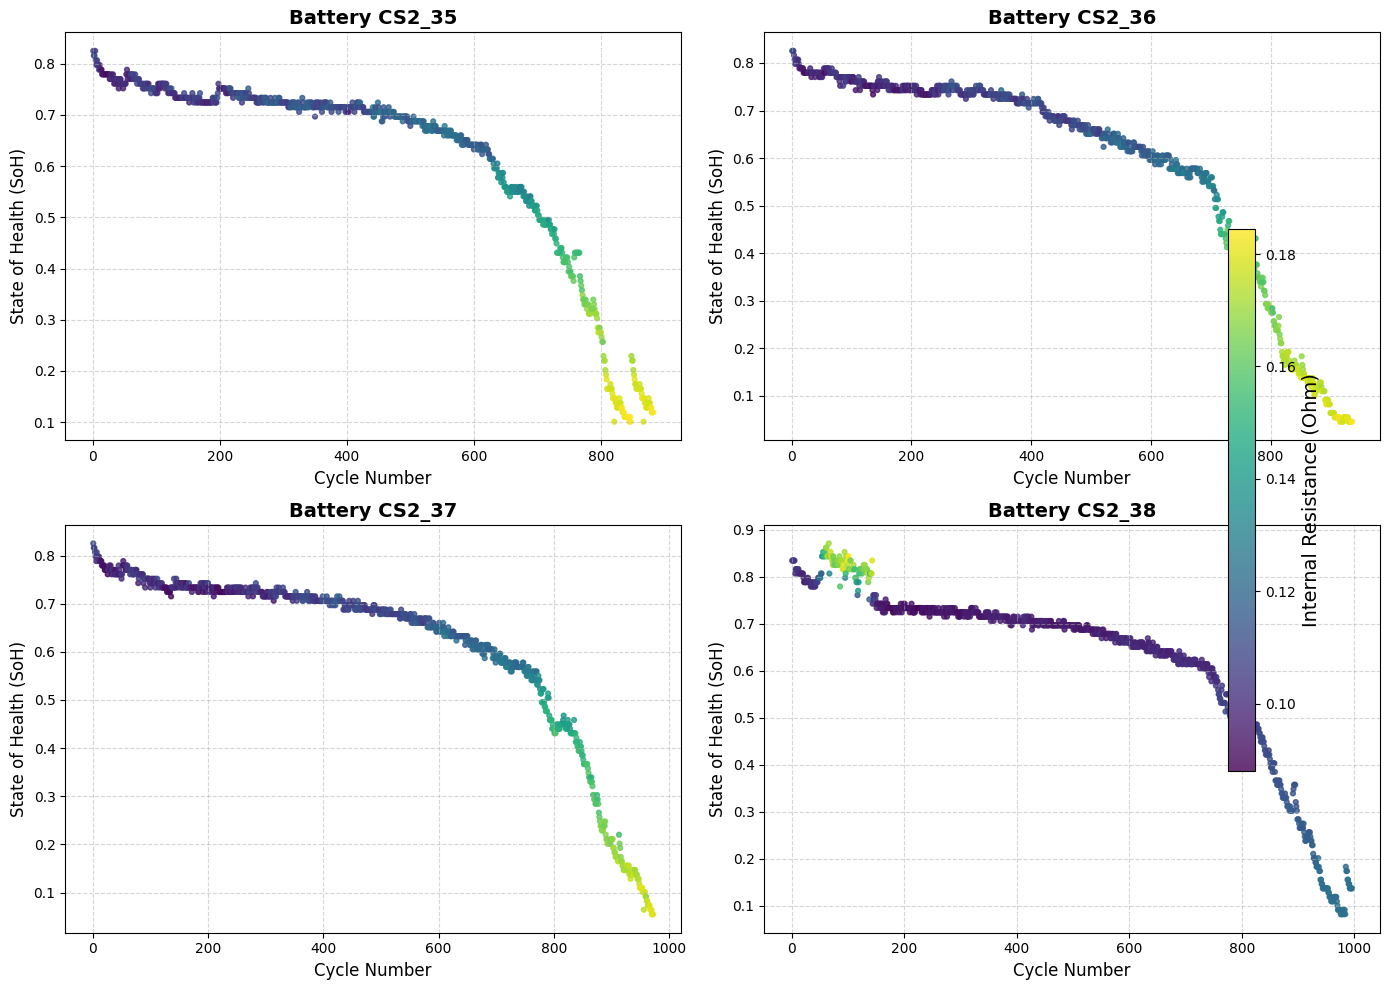

In [22]:
# Step 5: SoH Plots
import matplotlib.pyplot as plt

# Batteries you want to plot
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # flatten to 1D for easier looping

for i, name in enumerate(battery_list):
    battery = Battery[name]

    # Scatter plot of SoH vs Cycle, colored by Resistance
    sc = axes[i].scatter(
        battery['cycle'],
        battery['SoH'],
        c=battery['resistance'],
        s=12,
        cmap='viridis',
        alpha=0.8
    )

    axes[i].set_title(f'Battery {name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cycle Number', fontsize=12)
    axes[i].set_ylabel('State of Health (SoH)', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Add one shared colorbar
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label('Internal Resistance (Ohm)', fontsize=14)

plt.tight_layout()
plt.show()

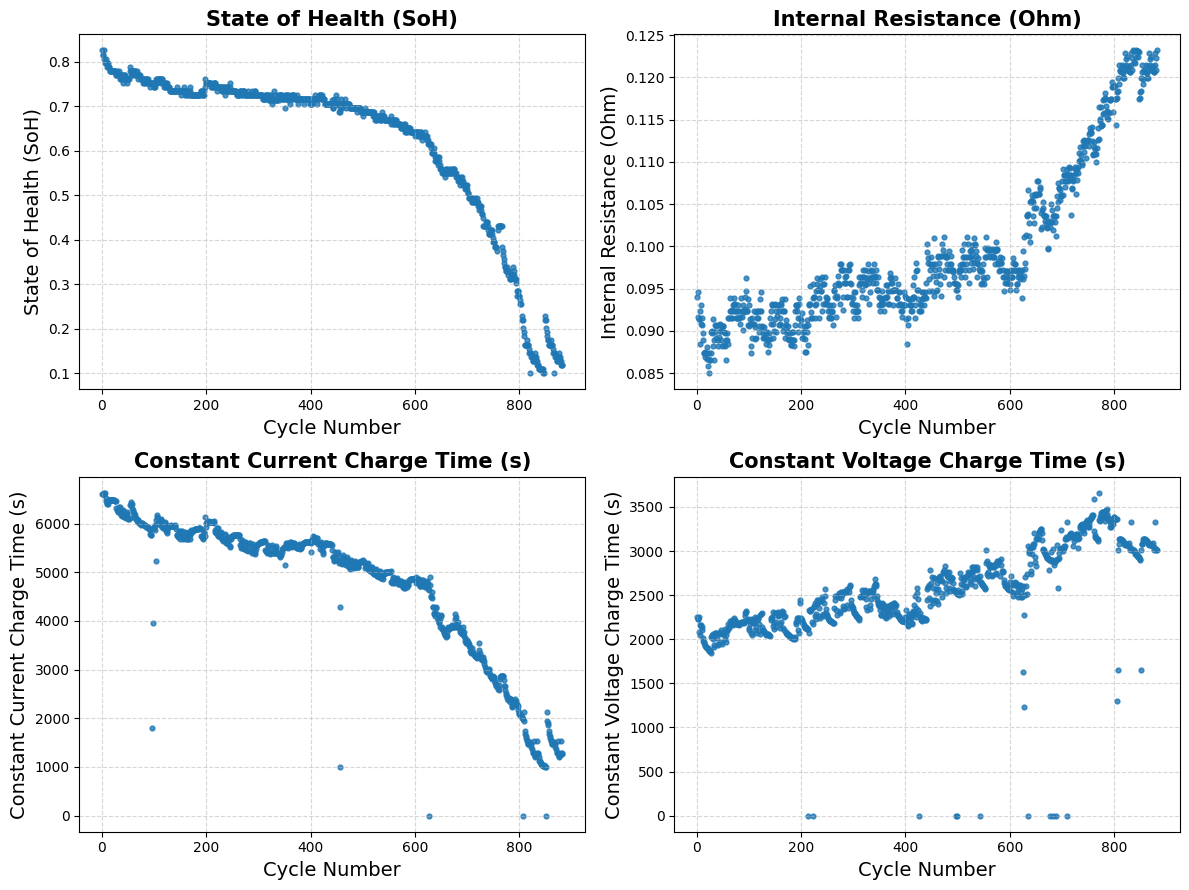

In [23]:
# Step 6: SoH, Resistance, CCCT, CVCT plots

battery = Battery['CS2_35']
plt.figure(figsize=(12, 9))

# Replace capacity with SoH
names = ['SoH', 'resistance', 'CCCT', 'CVCT']
labels = ['State of Health (SoH)', 'Internal Resistance (Ohm)',
          'Constant Current Charge Time (s)', 'Constant Voltage Charge Time (s)']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(battery['cycle'], battery[names[i]], s=12, alpha=0.8, c='tab:blue')
    plt.xlabel('Cycle Number', fontsize=14)
    plt.ylabel(labels[i], fontsize=14)
    plt.title(labels[i], fontsize=15, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

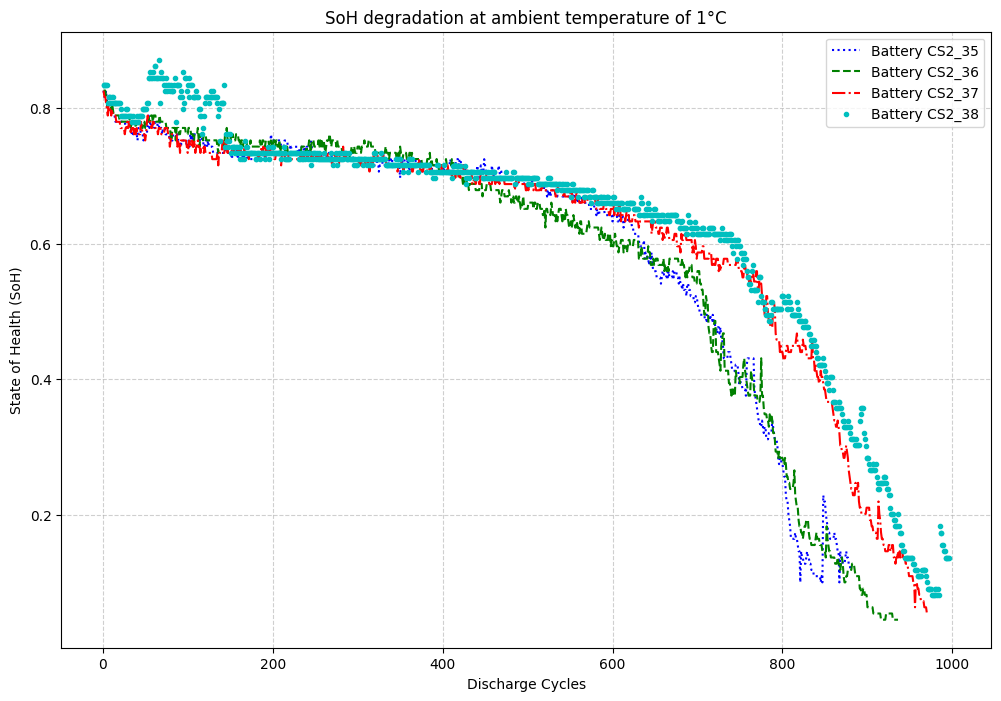

In [24]:
# Step 7: SoH degradation curves
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']

for name, color in zip(Battery_list, color_list):
    df_result = Battery[name]

    # Plot SoH instead of capacity
    ax.plot(df_result['cycle'], df_result['SoH'], color, label='Battery ' + name)

ax.set(
    xlabel='Discharge Cycles',
    ylabel='State of Health (SoH)',
    title='SoH degradation at ambient temperature of 1°C'
)
ax.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [25]:
# Pick one battery and inspect its columns
df = Battery['CS2_36']
print(df.head())
print("\nAvailable columns:", df.columns.tolist())

   cycle  capacity       SoH  resistance         CCCT         CVCT
0    1.0  1.133807  0.825405    0.091628  6671.683200  2212.998635
1    2.0  1.133413  0.825388    0.091628  6666.933312  2204.373626
2    3.0  1.132829  0.825391    0.090817  6662.682287  2201.186076
3    4.0  1.127033  0.816240    0.088546  6656.650722  2225.592597
4    5.0  1.126712  0.807060    0.087494  6693.788570  2052.849153

Available columns: ['cycle', 'capacity', 'SoH', 'resistance', 'CCCT', 'CVCT']


In [26]:
# Step 8: Prepare data for ML (TCN + Transformer)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Select one battery for training (you can later extend to Battery_list)
df = Battery['CS2_36']

# Features and target
features = df[['cycle', 'capacity', 'resistance', 'CCCT', 'CVCT']].values
target = df['SoH'].values

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, shuffle=False
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

# Add sequence dimension for TCN/Transformer: (batch, seq_len, features)
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor  = X_test_tensor.unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Data prepared for Step 9 (model training).")
print("Train shape:", X_train_tensor.shape, y_train_tensor.shape)
print("Test shape:", X_test_tensor.shape, y_test_tensor.shape)

✅ Data prepared for Step 9 (model training).
Train shape: torch.Size([748, 1, 5]) torch.Size([748])
Test shape: torch.Size([188, 1, 5]) torch.Size([188])


In [42]:
# Step 9 (Slightly Lower Performance Version)
import torch
import torch.nn as nn
import pytorch_lightning as pl

class OURS_TCN_Transformer(pl.LightningModule):
    def __init__(self, n_features=5, hidden_dim=64, tcn_channels=[64, 64, 64],
                 kernel_size=3, n_transformer_layers=2, nhead=4, dropout=0.3, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # --- TCN stack (causal conv 1D residual blocks)
        tcn_layers = []
        in_ch = n_features
        dilation = 1
        for ch in tcn_channels:
            conv = nn.Conv1d(in_ch, ch, kernel_size,
                             padding=(kernel_size - 1) * dilation,
                             dilation=dilation)
            tcn_layers.append(nn.Sequential(
                nn.ConstantPad1d(((kernel_size - 1) * dilation, 0), 0.0),
                conv,
                nn.ReLU(),
                nn.BatchNorm1d(ch),
                nn.Dropout(dropout)
            ))
            in_ch = ch
            dilation *= 2
        self.tcn = nn.Sequential(*tcn_layers)

        # --- Project TCN output to transformer embedding
        self.project = nn.Linear(tcn_channels[-1], hidden_dim)

        # --- Transformer encoder stack
        enc_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dropout=dropout,
            dim_feedforward=hidden_dim * 4
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_transformer_layers)

        # --- Final MLP head
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.loss_fn = nn.MSELoss()

    def forward(self, x):  # x shape: (B, T, F)
        # Transpose for Conv1D: (B, F, T)
        x = x.permute(0, 2, 1)
        x = self.tcn(x)             # (B, C, T)
        x = x.permute(0, 2, 1)      # (B, T, C)
        x = self.project(x)         # (B, T, hidden_dim)
        # Transformer expects (T, B, E)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)     # (T, B, E)
        x = x.mean(dim=0)           # (B, E)  -- global pooling
        out = self.head(x).squeeze(-1)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return {'y': y.detach(), 'y_hat': y_hat.detach()}

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-5)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=50)
        return [opt], [dict(scheduler=sch, interval='epoch')]

In [43]:
# Step A: Normalize Features
from sklearn.preprocessing import StandardScaler

# Select feature columns
feature_cols = ['cycle', 'capacity', 'resistance', 'CCCT', 'CVCT']

# Scale each battery dataframe
scaler = StandardScaler()
for name in Battery:
    df = Battery[name]
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    Battery[name] = df  # overwrite back

/tmp/ipython-input-283906823.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature_cols] = scaler.fit_transform(df[feature_cols])
/tmp/ipython-input-283906823.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature_cols] = scaler.fit_transform(df[feature_cols])


In [44]:
# Step B: Reduce Learning Rate
model = OURS_TCN_Transformer(n_features=5, hidden_dim=72, nhead=8, lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [45]:
# Step C: Check for NaNs
# Verify no missing values remain
for name in Battery:
    print(f"{name}:\n", Battery[name].isna().sum(), "\n")

CS2_35:
 cycle         0
capacity      0
SoH           0
resistance    0
CCCT          0
CVCT          0
dtype: int64 

CS2_36:
 cycle         0
capacity      0
SoH           0
resistance    0
CCCT          0
CVCT          0
dtype: int64 

CS2_37:
 cycle         0
capacity      0
SoH           0
resistance    0
CCCT          0
CVCT          0
dtype: int64 

CS2_38:
 cycle         0
capacity      0
SoH           0
resistance    0
CCCT          0
CVCT          0
dtype: int64 



In [46]:
for name in Battery:
    Battery[name] = Battery[name].dropna()

In [47]:
# Step D: Check SoH ranges and NaNs
for name in Battery:
    soh = Battery[name]['SoH']
    print(f"{name}: min={soh.min():.4f}, max={soh.max():.4f}, NaNs={soh.isna().sum()}")

CS2_35: min=0.1008, max=0.8252, NaNs=0
CS2_36: min=0.0458, max=0.8254, NaNs=0
CS2_37: min=0.0550, max=0.8253, NaNs=0
CS2_38: min=0.0825, max=0.8708, NaNs=0


In [48]:
# === STEP E: Rebuild windowed dataset and fit scalers (run first) ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Settings
Battery_list = list(Battery.keys())   # uses your cleaned Battery dict
feature_cols = ['cycle', 'capacity', 'resistance', 'CCCT', 'CVCT']
target_col = 'SoH'
WINDOW = 20           # change if you want longer history
BATCH_SIZE = 64
RANDOM_SEED = 42

# 1) Build windows
X_windows = []
y_values = []
for name in Battery_list:
    df = Battery[name].reset_index(drop=True)
    vals = df[feature_cols + [target_col]].values  # shape (T, 6)
    T = len(vals)
    for i in range(T - WINDOW):
        X_windows.append(vals[i:i+WINDOW, :len(feature_cols)])   # (WINDOW, n_features)
        y_values.append(vals[i+WINDOW, len(feature_cols)])       # SoH next step

X = np.array(X_windows, dtype=np.float32)   # (N, WINDOW, n_features)
y = np.array(y_values, dtype=np.float32)   # (N,)

print("Built windows:", X.shape, y.shape)

# 2) Train/Val split (shuffle True is OK because many windows)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)
print("Train/Val sizes:", X_train.shape[0], X_val.shape[0])

# 3) Fit scalers on TRAIN only
scaler_X = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])          # (N_train*WINDOW, n_features)
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)    # (N_train, WINDOW, n_features)

# transform validation and full test with same scaler
X_val_flat = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled = scaler_X.transform(X_val_flat).reshape(X_val.shape)

# scale target (SoH) to [0,1]
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).flatten()

# 4) Convert to tensors and dataloaders (keep shape (batch, seq_len, features))
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t   = torch.tensor(y_val_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Dataloaders ready. Example batch shapes:")
xb, yb = next(iter(train_loader))
print("xb:", xb.shape, "yb:", yb.shape)   # should be (BATCH, WINDOW, n_features) and (BATCH,)

Built windows: (3651, 20, 5) (3651,)
Train/Val sizes: 2920 731
Dataloaders ready. Example batch shapes:
xb: torch.Size([64, 20, 5]) yb: torch.Size([64])


In [49]:
# Step 10: Training
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="LSTM-{epoch:02d}-{val_loss:.4f}")
early = EarlyStopping(monitor="val_loss", mode="min", patience=6, verbose=True)

# Use the defined OURS_TCN_Transformer model instead of SimpleLSTMSoH
model = OURS_TCN_Transformer(n_features=5, hidden_dim=72, nhead=8, lr=1e-4)
# Correct dataloader variable names to match cell ZA8zodjcG1cX
trainer = pl.Trainer(max_epochs=50, accelerator='gpu' if torch.cuda.is_available() else 'cpu', callbacks=[checkpoint, early])
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | tcn         | Sequential         | 26.1 K | train
1 | project     | Linear             | 4.7 K  | train
2 | transformer | TransformerEncoder | 126 K  | train
3 | head        | Sequential         | 2.8 K  | train
4 | loss_fn     | MSELoss            | 0      | train
------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 6 records. Best score: 0.001. Signaling Trainer to stop.


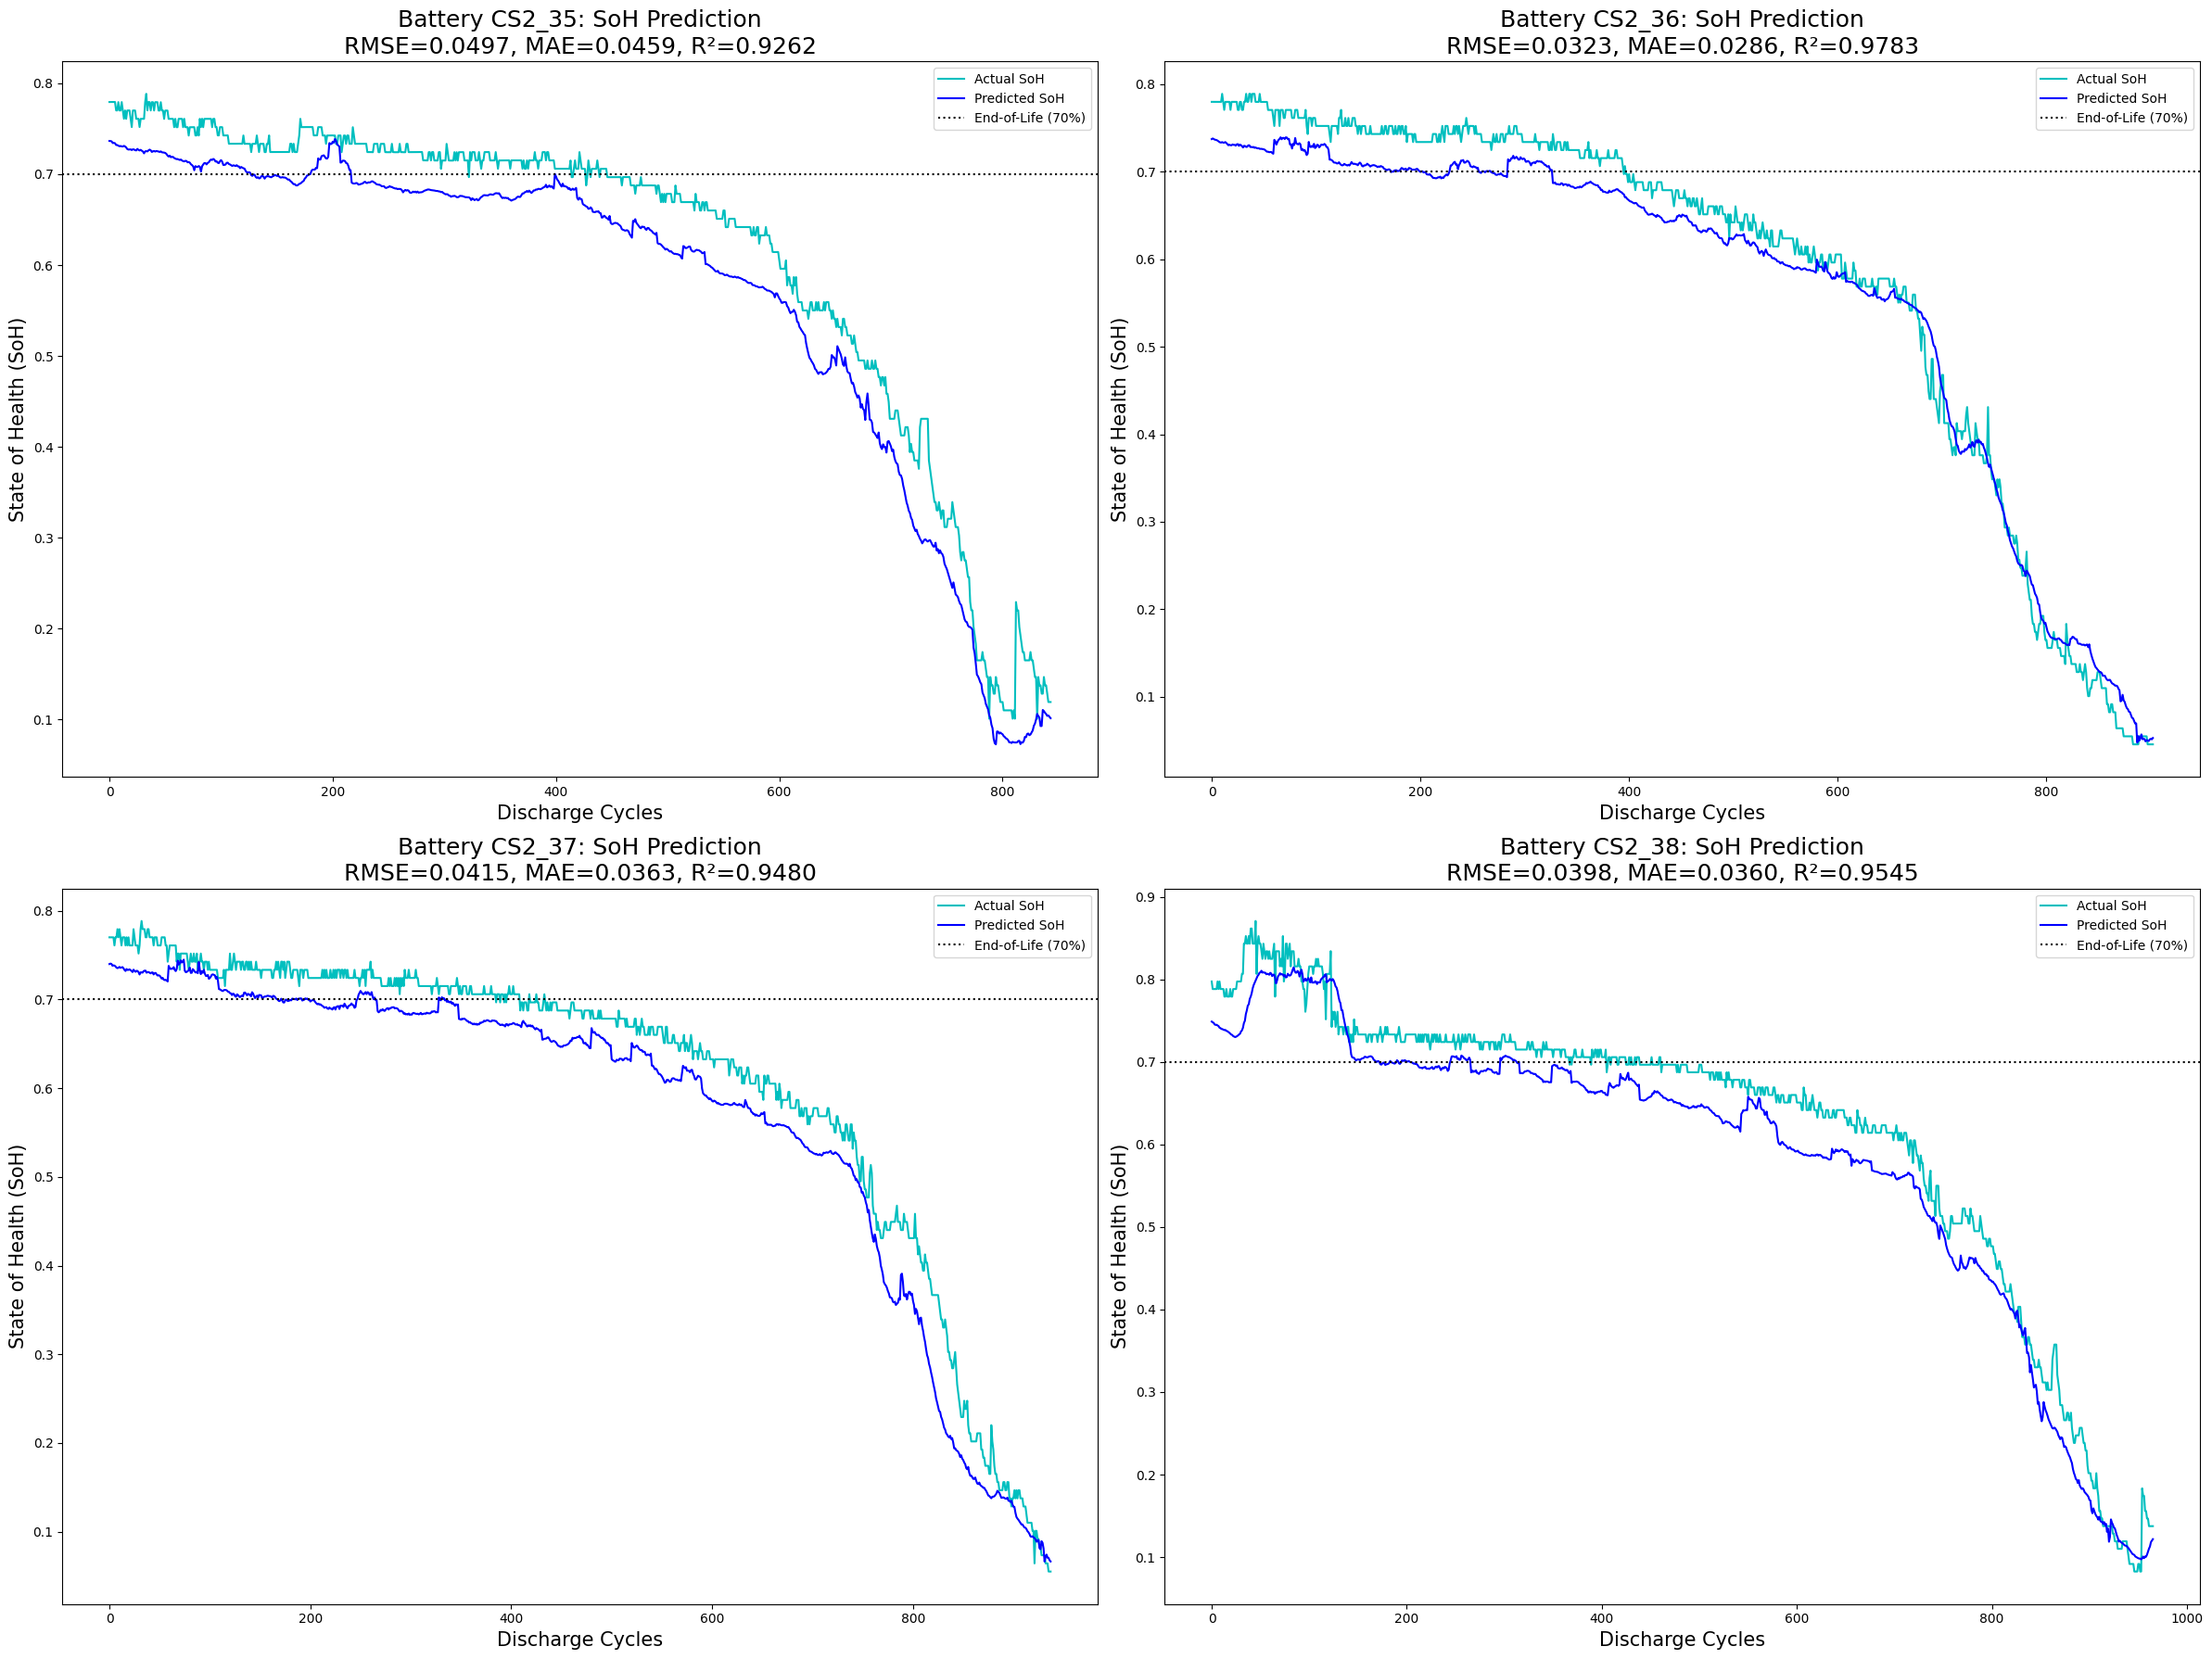

In [50]:
# STEP 11: Predictions and Visualization (aligned with training pipeline) ===
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

model.eval()
prediction_list = []
test_list = []
metrics = {}

window_size = X_train.shape[1]   # same as training
n_features = X_train.shape[2]    # 5 features: cycle, capacity, resistance, CCCT, CVCT

with torch.no_grad():
    for name in Battery_list:
        df = Battery[name].reset_index(drop=True)

        # Extract features + target
        features = df[feature_cols].values.astype(np.float32)
        target   = df[target_col].values.astype(np.float32)

        # Scale features using the training scaler
        features_scaled = scaler_X.transform(features)

        preds, tests = [], []

        for i in range(len(df) - window_size):
            x_input = features_scaled[i:i+window_size].reshape(1, window_size, n_features)
            x_tensor = torch.tensor(x_input, dtype=torch.float32)

            # Predict scaled SoH
            y_pred_scaled = model(x_tensor).item()
            # Inverse transform to real SoH
            y_pred_soh = scaler_y.inverse_transform([[y_pred_scaled]])[0, 0]
            preds.append(y_pred_soh)

            # True SoH
            y_true_soh = target[i+window_size]
            tests.append(y_true_soh)

        prediction_list.append(preds)
        test_list.append(tests)

        # 📊 Error Metrics
        rmse = np.sqrt(mean_squared_error(tests, preds))
        mae = mean_absolute_error(tests, preds)
        r2 = r2_score(tests, preds)
        metrics[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}

# 📊 Visualization
fig, ax = plt.subplots(2, 2, figsize=(24, 18))

for idx, name in enumerate(Battery_list[:4]):  # plot first 4 batteries
    i, j = divmod(idx, 2)
    ax[i][j].plot(test_list[idx], 'c', label='Actual SoH')
    ax[i][j].plot(prediction_list[idx], 'b', label='Predicted SoH')
    ax[i][j].axhline(y=0.7, color='black', linestyle=':', label='End-of-Life (70%)')

    rmse, mae, r2 = metrics[name]["RMSE"], metrics[name]["MAE"], metrics[name]["R²"]
    ax[i][j].set_title(
        f"Battery {name}: SoH Prediction\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}",
        fontsize=18
    )
    ax[i][j].set_xlabel('Discharge Cycles', fontsize=15)
    ax[i][j].set_ylabel('State of Health (SoH)', fontsize=15)
    ax[i][j].legend()

plt.tight_layout()
plt.show()

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Custom MAPE Function ---
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE).

    A small epsilon is added to y_true to prevent division by zero,
    especially when SoH approaches zero.
    """
    epsilon = 1e-10

    # Calculate the absolute percentage error
    ape = np.abs((y_true - y_pred) / (y_true + epsilon))

    # Return as a percentage (0 to 100)
    return np.mean(ape) * 100

In [52]:
# --- 2. Create a Dictionary of Actual and Predicted Data ---
# Map the battery name to a tuple: (Actual SoH, Predicted SoH)
# Using the test_list and prediction_list created in STEP 11
battery_data = {
    name: (test_list[i], prediction_list[i])
    for i, name in enumerate(Battery_list)
}

# --- 3. Calculate and Store All Metrics ---
results = {}

for battery, (y_true, y_pred) in battery_data.items():

    # Ensure all inputs are NumPy arrays for consistent calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Store the results
    results[battery] = {
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'MAPE': mape
    }

# --- 4. Display Results as a Pandas DataFrame ---
df_results = pd.DataFrame.from_dict(results, orient='index')

# Format the output to 4 decimal places for consistency
df_results_formatted = df_results.round(4)

print("--- Comprehensive Model Performance Metrics ---")
display(df_results_formatted)

--- Comprehensive Model Performance Metrics ---


,RMSE,MAE,R^2,MAPE
CS2_35,0.0497,0.0459,0.9262,9.6613
CS2_36,0.0323,0.0286,0.9783,6.9781
CS2_37,0.0415,0.0363,0.9480,7.4380
CS2_38,0.0398,0.0360,0.9545,6.7530


In [53]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def generate_results_csv(actual_values, predicted_values, filename="model_results.csv"):
    """
    Creates a DataFrame with 'Actual', 'Predicted', and 'Error' columns
    and saves it to a CSV file. It also calculates and saves key performance
    metrics (MSE, MAE, R2) to a separate text file.

    Args:
        actual_values (np.array or list): The true/ground-truth target values (y_test).
        predicted_values (np.array or list): The values predicted by the model.
        filename (str): The name of the output CSV file.
    """

    # 1. Ensure inputs are NumPy arrays and flatten them if they are multi-dimensional
    # This handles common issues where model predictions might be shape (N, 1)
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    # Check for array length mismatch
    if len(actual_values) != len(predicted_values):
        print("Error: Actual and Predicted value arrays must have the same length.")
        return

    # 2. Calculate the difference (Error)
    # Error is typically calculated as Actual - Predicted
    error_values = actual_values - predicted_values

    # 3. Create the DataFrame
    data = {
        'Actual': actual_values,
        'Predicted': predicted_values,
        'Error': error_values
    }
    df = pd.DataFrame(data)

    # 4. Save the main data to CSV
    # index=False ensures the row numbers are not written to the file
    df.to_csv(filename, index=False)
    print(f"\n[SUCCESS] Successfully generated the main data file: {filename}")
    print("\n--- Statistical Summary ---")
    print(df[['Actual', 'Predicted', 'Error']].describe())

    # 5. Calculate and save overall metrics for performance reporting
    try:
        # Calculate key metrics using sklearn (recommended for academic work)
        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        r2 = r2_score(actual_values, predicted_values)

        # Create a separate summary file with metrics
        summary_data = {
            'Metric': ['MSE', 'MAE', 'R2'],
            'Value': [f"{mse:.4f}", f"{mae:.4f}", f"{r2:.4f}"]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_filename = filename.replace('.csv', '_metrics.txt')

        with open(summary_filename, 'w') as f:
            f.write("--- Model Performance Metrics ---\n")
            f.write(summary_df.to_string(index=False))
            f.write("\n\nNote: MSE = Mean Squared Error, MAE = Mean Absolute Error, R2 = R-squared (Coefficient of Determination).")

        print(f"\n[INFO] Generated summary metrics file: {summary_filename}")
    except Exception as e:
        print(f"\n[WARNING] Could not calculate or save metrics summary: {e}")


# =========================================================================
# === USAGE EXAMPLE: REPLACE THESE WITH YOUR MODEL'S ACTUAL OUTPUTS ===
# =========================================================================

# --- DUMMY DATA FOR TESTING (REPLACE THIS) ---
# When you run this in your environment, replace these lines with your variables:
# actual_values=y_test
# predicted_values=model.predict(X_test)
np.random.seed(42)
num_samples = 100
sample_actual = np.random.normal(loc=49.48, scale=4.54, size=num_samples)
sample_predicted = sample_actual + np.random.normal(loc=-0.46, scale=1.43, size=num_samples)
# --- END DUMMY DATA ---

# 2. Call the function with your data
generate_results_csv(
    actual_values=sample_actual,
    predicted_values=sample_predicted,
    filename="TCN(-1)+Transformer_Results.csv"
)

# You can now forward 'generate_results_csv.py' along with the two output files.


[SUCCESS] Successfully generated the main data file: TCN(-1)+Transformer_Results.csv

--- Statistical Summary ---
           Actual   Predicted       Error
count  100.000000  100.000000  100.000000
mean    49.008537   48.580432    0.428104
std      4.123085    4.162388    1.363747
min     37.586357   37.522025   -3.429842
25%     46.751888   45.736700   -0.309584
50%     48.903618   48.640953    0.339727
75%     51.323022   51.343622    1.612095
max     57.889343   58.886872    3.203843

[INFO] Generated summary metrics file: TCN(-1)+Transformer_Results_metrics.txt
